##SmartRIVER  forecats system
notebook created  by GECOsistema Srl - Piazza Maltesta 21 Rimini (Italy)
mail : home@gecosistema.it

---

DISCLAIMER:
This notebook and related sample data are provided "as they are" only for demonstrational purposes, without warranty of any kind, either express or implied. The user is the sole responsible for any use of this notebook and GECOsistema will not be liable for any damages that the user may suffer in connection with using, modifying or distributing any part of  this notebook. 

---

The notebook is provided under Creative Commons CC BY-NC-SA  license
(https://creativecommons.org/licenses/by-nc-sa/4.0/ ) 

##Import packages 

In [5]:
import os

import pandas as pd
import numpy as np

from scipy.io import loadmat
import pandas as pd
import datetime as dt
import urllib

import warnings
warnings.filterwarnings('ignore')

from functools import reduce

import pickle
from pickle import dump
from pickle import load
import os.path
from google.colab import files

#plotting components 
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn
import seaborn as sns

#metrics and scalers 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

##MOUNT GDRIVE

In [6]:
# monunt your gdrive 
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

!ls /content/gdrive/

Mounted at /content/gdrive/
MyDrive  Shareddrives


In [ ]:
#set path to gdrive working directory where csv dataset has been stored, you can upload the  example dataset   Discharge.csv  
workdir  = "/content/gdrive/My Drive/SmartRIVER"

%cd "$workdir"
!ls

/content/gdrive/My Drive/SmartRIVER
Discharge.csv


In [ ]:
#simplifications : - this sample script  is not  making use of target differentiation od features  engineering, corresponding options are set false by default ,
#                  - the forecast is performed for one time step and no fold column is used 
#                  - following  lines will disable options by default, do not turn options on as realated blocks have been removed 
Timeshiftoption= False
UseDifferencing = False
TargetDifferencing = False
lagtime=0
lagH20=0
UsingFolds = False
eng_list=(' ',)
targetshift=0          
timeshift=0     

##1)DATA READ AND PREPARATION

###Load and set target

In [ ]:
#FILENAME of the CSV to load , 
#ATTENTION, first column with 'data', second column with target variable 

PIDarray=pd.read_csv('Discharge.csv') 

In [ ]:
#PRINT LIST OF COLUMNS
my_list = PIDarray.columns.values.tolist()
my_listoriginal = PIDarray.columns.values.tolist()
# dont change this line: 
my_listoriginal_eng=my_listoriginal.copy()
print(my_list)



['data', 'Dis', 'V1', 'V2', 'V3', 'V4', 'V5']


In [ ]:
#Declare Target variable 
response = 'Dis' #TARGET to be assigned from target array 
print(response)
responsecol=PIDarray.columns.get_loc(response)
print(responsecol)

#do not change this line 
Diff_list=(response,)

Dis
1


In [ ]:
# FIRST save original target  column  undifferrenced and with data for use later on in metrics calculation 
#Attention:choose the right position 
TargetArray=PIDarray.iloc[:,[0,responsecol]]
TargetArray


,data,Dis
0,1/15/2005,0.89472
1,1/29/2005,2.39324
2,2/12/2005,3.74700
3,2/26/2005,2.25622
4,3/12/2005,1.47820
...,...,...
399,5/30/2020,0.54570
400,6/13/2020,0.30452
401,6/27/2020,1.95408
402,7/11/2020,0.10622


###Fill nan

In [ ]:
#interpolate with linear interpolation  missing values 

PIDarray.interpolate(method='linear', inplace=True)
PIDarray

,data,Dis,V1,V2,V3,V4,V5
0,1/15/2005,0.89472,1.509,54.2,10.553,72.457,14.306
1,1/29/2005,2.39324,1.227,47.0,-0.107,70.939,3.069
2,2/12/2005,3.74700,4.124,73.8,4.299,70.241,70.727
3,2/26/2005,2.25622,1.817,108.2,5.987,77.030,6.424
4,3/12/2005,1.47820,1.165,27.2,3.403,64.560,18.876
...,...,...,...,...,...,...,...
399,5/30/2020,0.54570,0.709,17.0,17.287,72.012,36.304
400,6/13/2020,0.30452,0.436,9.8,17.357,77.839,2.271
401,6/27/2020,1.95408,0.272,0.4,22.239,64.346,7.948
402,7/11/2020,0.10622,0.154,26.8,18.625,63.616,5.498


###Remove 'Data' column before normalizing

---
drop Data column with non numeric values 

In [ ]:
#  drop  data to be reused it later on  
DataCol=PIDarray['data']
#print(DataCol)
PIDarray=PIDarray.drop(columns=['data']) 

###Normalization
---
if needed


In [ ]:
#Declare option

UseNormalization = True  #True False

In [ ]:
TargetArray

,data,Dis
0,1/15/2005,0.89472
1,1/29/2005,2.39324
2,2/12/2005,3.74700
3,2/26/2005,2.25622
4,3/12/2005,1.47820
...,...,...
399,5/30/2020,0.54570
400,6/13/2020,0.30452
401,6/27/2020,1.95408
402,7/11/2020,0.10622


In [ ]:
#make Targetarray of differenced var'iable, it's diffeent from  orignal TargetArray and it's used for normalization purposes only 
Targetarray=TargetArray[[response]]

#Targetarray=PIDarray.iloc[:,[responsecol-2]]
Targetarray

,Dis
0,0.89472
1,2.39324
2,3.74700
3,2.25622
4,1.47820
...,...
399,0.54570
400,0.30452
401,1.95408
402,0.10622


In [ ]:
##  load type of scalers 
# create scaler
#scaler = MinMaxScaler()
#scalertarget = MinMaxScaler()
scaler = StandardScaler()
scalertarget = StandardScaler()

In [ ]:
if UseNormalization == True:  #True, False
# fit and transform in one step
  PIDarray[PIDarray.columns]= scaler.fit_transform(PIDarray[PIDarray.columns])
  Targetarray[Targetarray.columns]= scalertarget.fit_transform(Targetarray[Targetarray.columns])
#PIDarray.to_csv("norm.csv")

###Add  'Data' column  after  normalizing

In [ ]:
# add data column back 
PIDarray=PIDarray.reset_index()
frames = [DataCol, PIDarray]
PIDarray=pd.concat(frames, axis=1, sort=True)
PIDarray=PIDarray.drop(columns=['index']) 

In [ ]:
PIDarray

,data,Dis,V1,V2,V3,V4,V5
0,1/15/2005,-0.495950,-0.241270,-0.209994,-0.047526,-0.427285,-0.738993
1,1/29/2005,0.107417,-0.339262,-0.326204,-1.503131,-0.568096,-1.112027
2,2/12/2005,0.652497,0.667408,0.106354,-0.901499,-0.632843,1.134016
3,2/26/2005,0.052247,-0.134244,0.661577,-0.671006,-0.003090,-1.000651
4,3/12/2005,-0.261017,-0.360806,-0.645780,-1.023847,-1.159817,-0.587282
...,...,...,...,...,...,...,...
399,5/30/2020,-0.636480,-0.519260,-0.810410,0.871991,-0.468564,-0.008725
400,6/13/2020,-0.733589,-0.614124,-0.926619,0.881550,0.071954,-1.138519
401,6/27/2020,-0.069408,-0.671112,-1.078337,1.548179,-1.179668,-0.950059
402,7/11/2020,-0.813433,-0.712115,-0.652236,1.054693,-1.247384,-1.031392


##2) FEATURE DROP (Optional)  and  save final  droplist ( Mandatory)

---

if any




In [ ]:
# selects featureslist to ignore by including them in droplist MANUALLY

drop_list1 = ['data']
PIDarray=PIDarray.drop(columns=drop_list1) ##elimina delle colonne 


#check is data is still among features 
datacontrol = "data" in PIDarray
if datacontrol== False:
  datashift=1
else:
  datashift=0

print('Data is  among features ='+str(datacontrol))

PIDarray



Data is  among features =False


,Dis,V1,V2,V3,V4,V5
0,-0.495950,-0.241270,-0.209994,-0.047526,-0.427285,-0.738993
1,0.107417,-0.339262,-0.326204,-1.503131,-0.568096,-1.112027
2,0.652497,0.667408,0.106354,-0.901499,-0.632843,1.134016
3,0.052247,-0.134244,0.661577,-0.671006,-0.003090,-1.000651
4,-0.261017,-0.360806,-0.645780,-1.023847,-1.159817,-0.587282
...,...,...,...,...,...,...
399,-0.636480,-0.519260,-0.810410,0.871991,-0.468564,-0.008725
400,-0.733589,-0.614124,-0.926619,0.881550,0.071954,-1.138519
401,-0.069408,-0.671112,-1.078337,1.548179,-1.179668,-0.950059
402,-0.813433,-0.712115,-0.652236,1.054693,-1.247384,-1.031392


In [ ]:
#PRINT LIST OF COLUMNS  ATTENTION: ALLWAYS Make this final list even if manual feature drop is not used 
my_listtemp = PIDarray.columns.values.tolist()
set_difference = set(my_listoriginal_eng) - set(my_listtemp)
drop_listfinal = list(set_difference)
print(drop_listfinal)

['data']


In [ ]:
#Find  Target variable position in feature selected dataframe 
sel_response = response #TARGET allaready assigned at the beginning 
print(sel_response)
sel_responsecol=PIDarray.columns.get_loc(sel_response)
print(sel_responsecol)

Dis
0


##3)TUNE MODELS

---
Exploiting  H2o Automl (https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)


### INSTALL H20



In [ ]:
!python --version

Python 3.7.14


In [ ]:
! apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
openjdk version "11.0.16" 2022-07-19
OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04)
OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)


In [ ]:
! pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init(nthreads = -1,max_mem_size = "30g")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmeypv8b0
  JVM stdout: /tmp/tmpmeypv8b0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmeypv8b0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_1nro6w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,30 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


### RUN H2O
a second  model  run may require runtime restart

In [ ]:
 #Simulation name
pixel="Discharge"

In [ ]:
#SPLIT TRAIN and test , test= All - train 

trainrow=365 #manually ASSIGN TRAIN ROW NUMBER keep the most recent  part of the datasetc as test 
traindf=PIDarray.iloc[:trainrow,:] #DATAFRAME TRAIN
testdf=PIDarray.iloc[trainrow:,:] #DATAFRAME TEST

traindf.to_csv('train'+str(pixel)+'.csv')
testdf.to_csv('test'+str(pixel)+'.csv')

# Load data into H2O
df_train = h2o.H2OFrame(traindf)
df_test = h2o.H2OFrame(testdf)

# Select aglorirthm to train  , pleaew refer to H20 documentation for aglorirtms and  other parameters  
aml = H2OAutoML(max_runtime_secs = 360 ,project_name = 'RA'+str(pixel), stopping_metric = "rmse", sort_metric = "rmse",include_algos = ['GBM'])              


#Train H2o Automl selecetd model 
aml.train( y = response, training_frame = df_train,leaderboard_frame = df_test,)

aml.leaderboard.head()



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_1_20221007_133945_model_514,0.481035,0.231395,0.337385,0.521537,0.231395
GBM_grid_1_AutoML_1_20221007_133945_model_188,0.483326,0.233604,0.345677,0.487584,0.233604
GBM_grid_1_AutoML_1_20221007_133945_model_570,0.485312,0.235528,0.346317,0.579354,0.235528
GBM_grid_1_AutoML_1_20221007_133945_model_148,0.490558,0.240647,0.353033,0.516228,0.240647
GBM_grid_1_AutoML_1_20221007_133945_model_186,0.491822,0.241889,0.351399,0.484769,0.241889
GBM_grid_1_AutoML_1_20221007_133945_model_55,0.491855,0.241921,0.351457,0.51861,0.241921
GBM_grid_1_AutoML_1_20221007_133945_model_227,0.494566,0.244596,0.357973,0.591376,0.244596
GBM_grid_1_AutoML_1_20221007_133945_model_124,0.49558,0.245599,0.367325,0.613802,0.245599
GBM_grid_1_AutoML_1_20221007_133945_model_513,0.495857,0.245875,0.35571,0.494982,0.245875
GBM_grid_1_AutoML_1_20221007_133945_model_6,0.496453,0.246466,0.351332,0.566348,0.246466


#### scores ( TEST_TRAIN MUST BE DEFINED) 

---
dedifference  and denormalize if needed


In [ ]:
#make prediction on test
#select model_id ,default leader = 1 
model_selected=h2o.get_model(aml.leaderboard.as_data_frame()['model_id'][0]) 
pred_test = model_selected.predict(df_test)

rmse_test = model_selected.model_performance(df_test).rmse()
print (rmse_test)
pred_test_df=pred_test.as_data_frame()

pred_train = model_selected.predict(df_train)
rmse_train = model_selected.model_performance(df_train).rmse()
print (rmse_train)
pred_train_df=pred_train.as_data_frame()

test_df=testdf.iloc[:, (sel_responsecol+1-datashift):(sel_responsecol+2-datashift)] #### attenzione può dare errore usare questa riga se 'data' rimane incluso nel dataset 
#test_df=testdf.iloc[:, (sel_responsecol+0-datashift):(sel_responsecol+1-datashift)] 

#testdf=testdf.dropna()  nan values shall be avoided filling them before 
comparison_test=pd.DataFrame()
test_df=test_df.reset_index()

comparison_test=pd.concat([pred_test_df[['predict']], test_df[[response]]], axis=1, sort=True)

comparison_test

#inverse scale prediction
if UseNormalization == True :
  col_names = comparison_test.columns
  features3 = comparison_test[col_names]
  scaled_features3 = pd.DataFrame(features3, columns = col_names)
  scaled_features3.head()
  re_scaled_features3 = scalertarget.inverse_transform(scaled_features3)
  re_scaled_df3 = pd.DataFrame(re_scaled_features3, columns = col_names)
else:
  re_scaled_df3=comparison_test


#dedifferencing target if necessary 
if Timeshiftoption == True:
  Qseed=TargetArray[trainrow-1+timeshift:trainrow+timeshift+lagtime]
else:
  Qseed=TargetArray[trainrow-1:trainrow+lagtime]

RowNum_results=len(re_scaled_df3)

if TargetDifferencing == True:
  for i in range (0,lagtime+1):
    re_scaled_df3.iloc[i, re_scaled_df3.columns.get_loc(response)] = re_scaled_df3.iloc[i, re_scaled_df3.columns.get_loc(response)]+Qseed.iloc[i, Qseed.columns.get_loc(response)]
    re_scaled_df3.iloc[i, re_scaled_df3.columns.get_loc('predict')] = re_scaled_df3.iloc[i, re_scaled_df3.columns.get_loc('predict')]+Qseed.iloc[i, Qseed.columns.get_loc(response)]
  for i in range (lagtime+1,RowNum_results):
    re_scaled_df3.iloc[i, re_scaled_df3.columns.get_loc(response)] = re_scaled_df3.iloc[i, re_scaled_df3.columns.get_loc(response)]+re_scaled_df3.iloc[i-1-lagtime, re_scaled_df3.columns.get_loc(response)]
    re_scaled_df3.iloc[i, re_scaled_df3.columns.get_loc('predict')] = re_scaled_df3.iloc[i, re_scaled_df3.columns.get_loc('predict')]+re_scaled_df3.iloc[i-1-lagtime, re_scaled_df3.columns.get_loc(response)]
re_scaled_df3


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
0.48103482413966503
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
0.5821465314909648


,predict,Dis
0,4.018705,4.98294
1,4.888683,4.03400
2,4.173080,4.06020
3,1.414146,1.48770
4,2.455460,0.91105
5,2.419899,0.87815
6,2.548847,4.16019
7,3.385388,2.98464
8,1.713683,2.02500
9,2.372496,2.12318


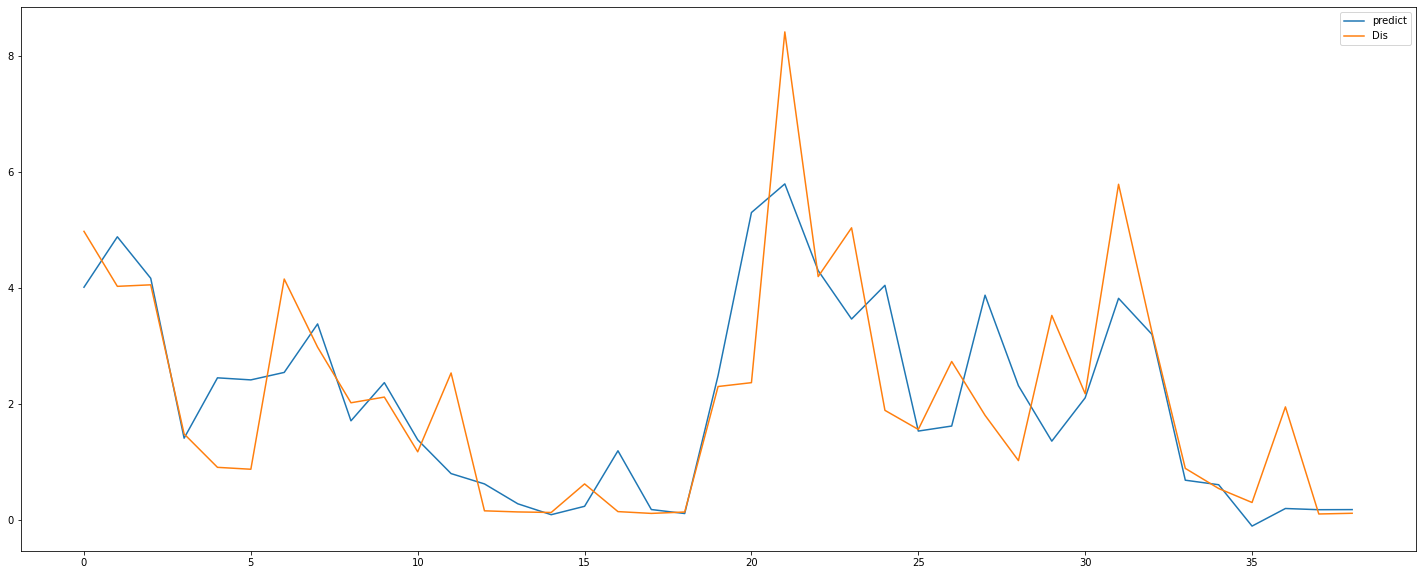

In [ ]:
import matplotlib.pyplot as plt
#import seaborn as sns

re_scaled_df3.plot(figsize=(25,10))



#comparison_test[['predict']].plot.line(figsize=(25,10))
#comparison[['Rain']].plot.line(figsize=(25,10))

plt.show()

In [ ]:
# summarize scores- next step predition VS naive forecast ( forecast = value at the time step before ) 
mae_n=[]
mae_p=[]
rmse_n=[]
rmse_p=[]
r2_diff_p=[]
re_scaled_df4=re_scaled_df3.copy()

#create time differenced naive predictor aoutput 
re_scaled_df4[response+'_-'+str(lagtime+1)]=re_scaled_df4[response].shift(periods=1+lagtime) ## genera la variabile a tempo -1

#cut lines at the beginnig to avoid NAN values
re_scaled_df4=re_scaled_df4.drop(re_scaled_df4.head(1+lagtime).index)


#add colunns with differenced data  for R2 
re_scaled_df4[response+'_dif'] = re_scaled_df4[response] - re_scaled_df4[response+'_-'+str(lagtime+1)]
re_scaled_df4['predict'+'_dif'] = re_scaled_df4['predict'] - re_scaled_df4[response+'_-'+str(lagtime+1)]

#calculate metrics
mean4=re_scaled_df4[response].mean(axis=0)
rmse_n=mean_squared_error(re_scaled_df4[response+'_-'+str(lagtime+1)],re_scaled_df4[response],squared=False)
rmse_n_perc=rmse_n/mean4
rmse_p=mean_squared_error(re_scaled_df4['predict'],re_scaled_df4[response],squared=False)
rmse_p_perc=rmse_p/mean4
mae_n=mean_absolute_error(re_scaled_df4[response+'_-'+str(lagtime+1)],re_scaled_df4[response])
mae_p=mean_absolute_error(re_scaled_df4['predict'],re_scaled_df4[response])
correlation_matrix = np.corrcoef(re_scaled_df4[response+'_dif'], re_scaled_df4['predict'+'_dif'])
correlation_xy = correlation_matrix[0,1]
r2_diff_p = correlation_xy**2
print('rmse-pred',rmse_p)
print('rmse-naive',rmse_n)
print('rmse-pred%',rmse_p_perc)
print('rmse-naive%',rmse_n_perc)
print('mae-pred',mae_p)
print('mae-naive',mae_n)
print('r2_diff_pred',r2_diff_p)

rmse-pred 1.2001646010445566
rmse-naive 1.9333983894455191
rmse-pred% 0.5854277348105631
rmse-naive% 0.9430915048105641
mae-pred 0.8346056909804451
mae-naive 1.3575763157894734
r2_diff_pred 0.61303881759488


#### models inspection 
---
and further feature selection basing on H2O models feat. importance 


['V3', 'V1', 'V5', 'V4', 'V2']
  variable  relative_importance  scaled_importance  percentage
0       V3           474.717010           1.000000    0.376453
1       V1           323.444397           0.681341    0.256493
2       V5           197.739578           0.416542    0.156808
3       V4           159.343170           0.335659    0.126360
4       V2           105.782570           0.222833    0.083886


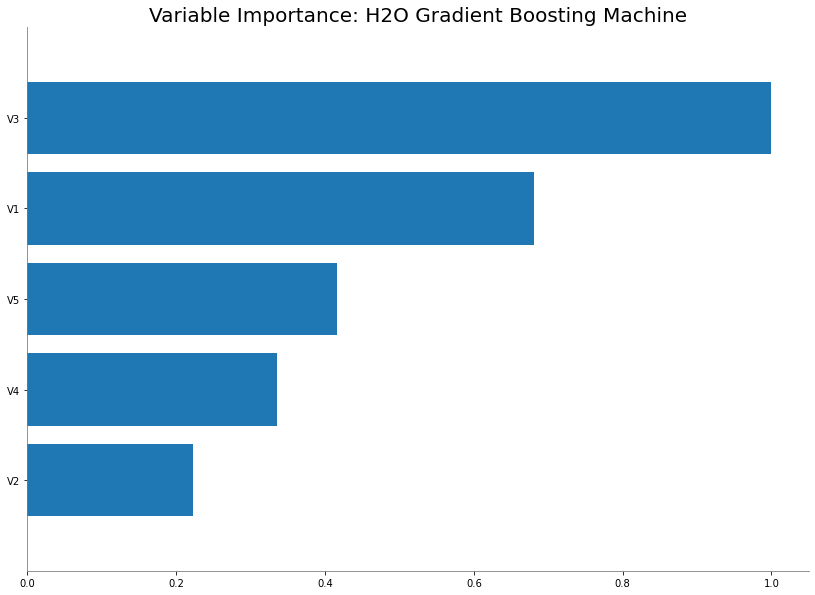

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.464928  0.0747989  0.408963      0.497891      0.435399      0.402004      0.580381
mean_residual_deviance  0.530183  0.200637   0.324774      0.56803       0.51065       0.400672      0.846791
mse                     0.530183  0.200637   0.324774      0.56803       0.51065       0.400672      0.846791
r2                      0.500184  0.0620504  0.550812      0.523475      0.535612      0.49582       0.395202
residual_deviance       0.530183  0.200637   0.324774      0.56803       0.51065       0.400672      0.846791
rmse                    0.718273  0.133546   0.56989       0.753677      0.714598      0.632986      0.920212
rmsle                   0.59131   0.0661074  0.598057      0.620215      0.5528

<Figure size 432x288 with 0 Axes>

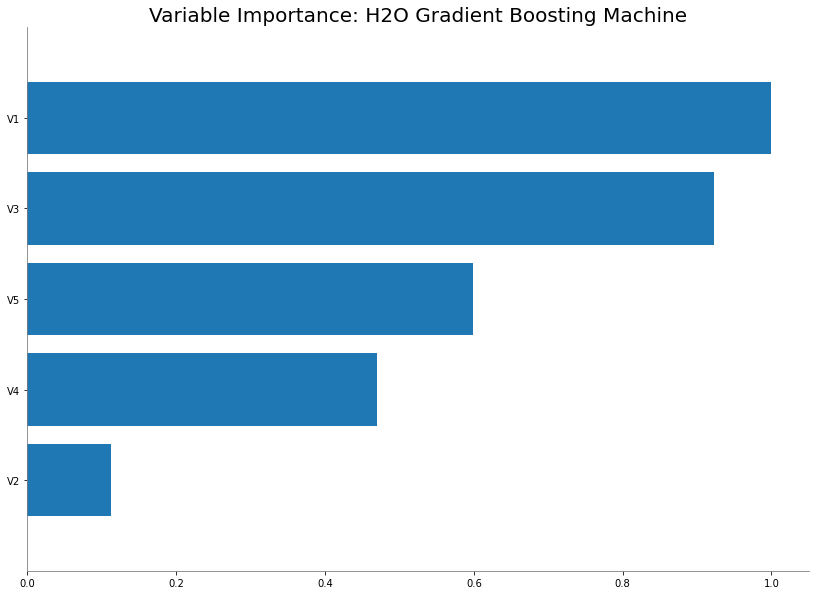

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.450562  0.091688   0.396534      0.478467      0.40861       0.370907      0.598292
mean_residual_deviance  0.497167  0.198195   0.322248      0.548697      0.436098      0.362314      0.816476
mse                     0.497167  0.198195   0.322248      0.548697      0.436098      0.362314      0.816476
r2                      0.531669  0.0690295  0.554305      0.539693      0.60341       0.544086      0.416854
residual_deviance       0.497167  0.198195   0.322248      0.548697      0.436098      0.362314      0.816476
rmse                    0.694861  0.133863   0.567669      0.740741      0.660377      0.601926      0.903591
rmsle                   0.569139  0.0903361  0.562075      0.604799      0.5290

<Figure size 432x288 with 0 Axes>

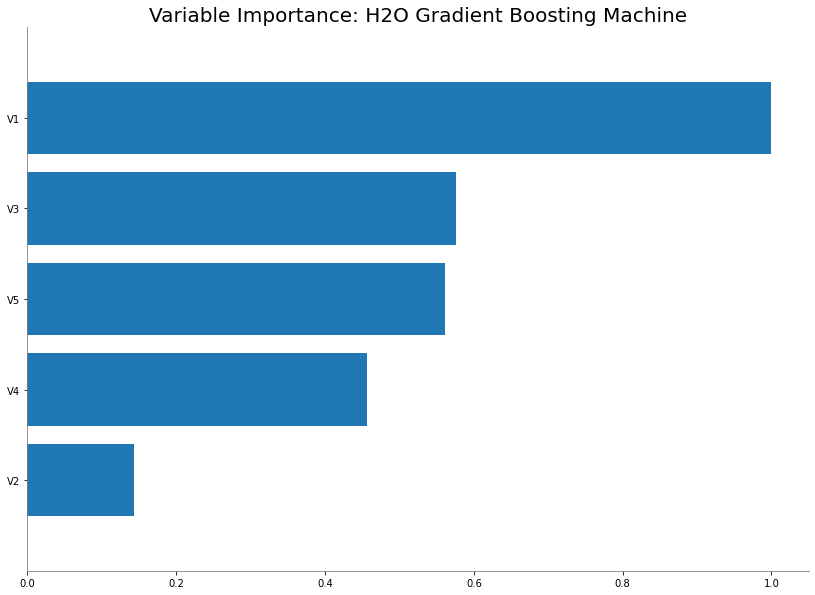

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.476415  0.0799725  0.419757      0.507448      0.472443      0.388852      0.593574
mean_residual_deviance  0.526524  0.199512   0.321943      0.586498      0.543237      0.361         0.81994
mse                     0.526524  0.199512   0.321943      0.586498      0.543237      0.361         0.81994
r2                      0.505761  0.0555688  0.554727      0.507981      0.505977      0.54574       0.41438
residual_deviance       0.526524  0.199512   0.321943      0.586498      0.543237      0.361         0.81994
rmse                    0.715323  0.136181   0.5674        0.765832      0.737046      0.600833      0.905505
rmsle                   0.657385  0.0657732  nan           0.665961      0.684676  

<Figure size 432x288 with 0 Axes>

In [ ]:
# after deciding  how many models, trained by defautl, you want to inspect  you may revise the feature importance and jump back to the MANUALFEATURE DROP section o reduce used features 
# number of  most important features  to rank 
nf=30

#number of models to extract feature importance from 
featnumber=3

# make a ditcionary  with a empy feature ist for every model 
list_of_lists = []

for i in range(0,featnumber):
  #model_selected=aml.leader
  model_selected=h2o.get_model(aml.leaderboard.as_data_frame()['model_id'][i])
  model_selected.varimp(use_pandas = True)
  model_selected._model_json['output']['variable_importances'].as_data_frame()

  #feature importance 
  df_importance=model_selected._model_json['output']['variable_importances'].as_data_frame()
  importance_list=df_importance["variable"].tolist()
  print(importance_list)
  print(df_importance[:nf])
  model_selected.varimp_plot()
  print(model_selected.cross_validation_metrics_summary())

  #list alla single dropfeature  lists from single models 
  my_listtemp = PIDarray.columns.values.tolist()
  if UsingFolds==True :
    my_listtemp .remove('fold')
  set_difference = set(my_listtemp) - set(importance_list[0:nf])
  drop_listH2o = list(set_difference)
  drop_listH2o.remove(response) ##remove target column if present in the list
  list_of_lists.append(drop_listH2o)

print(list_of_lists)


##4)DEPLOY MODELS

---
one by one 


In [ ]:
# save the model
# you can repet  this cell with as many models changing number and model id in the next lines 
sequence=1 #give a  number to  the model you want to save  
model = h2o.get_model(aml.leaderboard.as_data_frame()['model_id'][0]) # here you choose the  model id =  wich model from the currnet H20 run to save, 0 = leaderboard


save_path = workdir+'/H2o'+'/lag_'+str(lagH20)+'/model_'+str(sequence)
model_path = h2o.save_model(model=model, path = save_path , force=True)
# Download the MOJO and the resulting ``h2o-genmodel.jar`` file
# to a new **experiment** folder. Note that the ``h2o-genmodel.jar`` file
# is a library that supports scoring and contains the required readers
# and interpreters. This file is required when MOJO models are deployed
# to production. Be sure to specify the entire path, not just the relative path.
modelfile = model.download_mojo(path=save_path, get_genmodel_jar=True)

# in the same folder save all relevant settings to be loaded with the  model : final drop list, time shift and related feature list , scaler settings , differencing options 
#saving drop lits
completeName = os.path.join(save_path, "drop_listfinal"+".txt")         
file1 = open(completeName, "w") 
for s in drop_listfinal:
   file1.write(str(s) +"\n")
file1.close()

#saving differencing  list 
completeName = os.path.join(save_path, "Diff_list"+".txt")         
file2 = open(completeName, "w") 

for s in Diff_list:
   file2.write(str(s) +"\n")
file2.close()

#saving engineering  list 
completeName = os.path.join(save_path, "eng_list"+".txt")         
file3 = open(completeName, "w") 
for s in eng_list:
   file3.write(str(s) +"\n")
file3.close()

# pickle, to save other simulation options (target variable, differncing, normalizing, feature engineering  ) includingh complete model path 

completeName = os.path.join(save_path, "parameters"+".txt")   
with open(completeName, "wb") as f:
    pickle.dump([response,responsecol,UsingFolds,UseDifferencing,TargetDifferencing,UseNormalization,Timeshiftoption,timeshift,model_path], f)

#save scaler parameters
completeName = os.path.join(save_path, "scaler"+".sav")
with open(completeName, "wb") as f:
    pickle.dump(scaler,f) 

#save scalertarget parameters
completeName = os.path.join(save_path, "scalertarget"+".sav")
with open(completeName, "wb") as f:
    pickle.dump(scalertarget, f)


##5)LOAD MODELS
---
and if you want  run on separate csv  ,  save result for plotting and isnpection in csv format  

---
ATTENTION: loaded H20 version must be the same as the saved models for them  run, load a specific vesion @ a)INSTALL H2O if necessary

#### load csv

In [3]:
#FILENAME of the CSV to load , ATTENTION, use first column with data and name 'data', second column with target variable 
LOADarray=pd.read_csv('Discharge.csv') 
LOADarray

NameError: ignored

####load  settings 



In [4]:
# load  the model
l_lagH20=0 #do not change this line 

l_sequence=1 #HERE you decide the model to load from the ones you saved 


load_path = workdir+'/H2o'+'/lag_'+str(l_lagH20)+'/model_'+str(l_sequence)
#load   model settings to format CSV and extract/elaborate features 

#loading drop list
completeName = os.path.join(load_path, "drop_listfinal"+".txt")    
with open(completeName, 'r') as f:
   l_drop_listfinal = [line.rstrip('\n') for line in f]

#loading differencing  list 
completeName = os.path.join(load_path, "Diff_list"+".txt")    
with open(completeName, 'r') as f:
   l_Diff_list = [line.rstrip('\n') for line in f]
   
#loading engineering  list 
completeName = os.path.join(load_path, "eng_list"+".txt")    
with open(completeName, 'r') as f:
   l_eng_list = [line.rstrip('\n') for line in f]

# load simulation options (differencing, normalizing, feature engineering  ) 
completeName = os.path.join(load_path, "parameters"+".txt")  
with open(completeName, "rb") as f:  # Python 3: open(..., 'rb')
    l_response,l_responsecol,l_UsingFolds,l_UseDifferencing,l_TargetDifferencing,l_UseNormalization,l_Timeshiftoption,l_timeshift,l_model_path = pickle.load(f)

#load  scaler values 
completeName = os.path.join(load_path, "scaler"+".sav")
l_scaler = pickle.load(open(completeName, 'rb'))

#load  scalertarget values 
completeName = os.path.join(load_path, "scalertarget"+".sav")
l_scalertarget = pickle.load(open(completeName, 'rb'))
print(l_drop_listfinal)

NameError: ignored

####prepare dataframe 

In [ ]:
#prepare dataframe for model according to loaded settings 


# FIRST save original target  column  undifferrenced and with data for use later on in metrics calculation 
if l_UsingFolds==True:
  l_TargetArray=LOADarray.iloc[:,[0,(l_responsecol-1)]]
else:
  l_TargetArray=LOADarray.iloc[:,[0,l_responsecol]]

#FILLNAN: choose interpolation nmethod, default  linear  interpolation 
#LOADarray.fillna(method='ffill', inplace=True)
LOADarray.interpolate(method='linear', inplace=True)


#Differencing
if l_UseDifferencing == True:
  for  i in l_Diff_list:
    if i==l_response:
      LOADarray[str(i)]=LOADarray[str(i)].diff(periods=1+l_lagH20)
      for t in range(l_lagH20+1):
        LOADarray[str(i)].iloc[t] = 0 #fake value of zero for line 1+ l_lagH20 once differenced
    else:
      LOADarray[str(i)]=LOADarray[str(i)].diff(periods=1)
      LOADarray[str(i)].iloc[0] = 0 #fake value of zero for first line once differenced 

# save data column before drop to be reused it later on  
l_DataCol=LOADarray['data']

# transform in one step
if l_UseNormalization == True:
  LOADarray=LOADarray.drop(columns=['data'])
  LOADarray[LOADarray.columns]= l_scaler.transform(LOADarray[LOADarray.columns])
  LOADarray=LOADarray.reset_index()
  frames = [l_DataCol, LOADarray]
  LOADarray=pd.concat(frames, axis=1, sort=True)
  LOADarray=LOADarray.drop(columns=['index'])
  l_TargetArray=l_TargetArray.drop(columns=['data'])
  l_TargetArray[l_TargetArray.columns]= l_scalertarget.transform(l_TargetArray[l_TargetArray.columns])
  l_TargetArray=l_TargetArray.reset_index()
  frames = [l_DataCol, l_TargetArray]
  l_TargetArray=pd.concat(frames, axis=1, sort=True)
  l_TargetArray=l_TargetArray.drop(columns=['index'])

if l_Timeshiftoption== True:
  for  feat in l_eng_list:
    if feat==l_response:
      for t_d in range(1,l_timeshift+1):
          LOADarray[feat+'_t'+str(t_d+l_lagH20)]=LOADarray[feat].shift(periods=t_d+l_lagH20) ## genera la variabile a tempo -td
    else:
      for t_d in range(1,l_timeshift+1):
          LOADarray[feat+'_t'+str(t_d)]=LOADarray[feat].shift(periods=t_d) ## genera la variabile a tempo -td

#remove the first  X rows  in head(X)
if l_Timeshiftoption== True:
  LOADarray=LOADarray.drop(LOADarray.head(l_timeshift+l_lagH20).index)  #cancello le  X righe iniziali per il drop

#drop features 
l_drop_listfinal2=l_drop_listfinal.copy()
#l_drop_listfinal2.remove('data')
LOADarray=LOADarray.drop(columns=l_drop_listfinal2) ##elimina delle colonne 
LOADarray





#### run forecast

In [ ]:
#load model , parse dataframe and  run
loaded_model = h2o.load_model(l_model_path)
hf = h2o.H2OFrame(LOADarray)
l_pred= loaded_model.predict(hf)
l_pred=l_pred.as_data_frame()

#load comparison target 
l_test=LOADarray[[l_response]]

#make a unique dataframe
l_comparison_test=pd.DataFrame()
l_test=l_test.reset_index()
l_comparison_test=pd.concat([l_pred[['predict']], l_test[[l_response]]], axis=1, sort=True)

#inverse scale prediction if necessary 
if l_UseNormalization == True :
  col_names = l_comparison_test.columns
  l_features = l_comparison_test[col_names]
  scaled_l_features = pd.DataFrame(l_features, columns = col_names)
  scaled_l_features.head()
  re_scaled_df5 =l_scalertarget.inverse_transform(scaled_l_features)
  re_scaled_df5 = pd.DataFrame(re_scaled_df5, columns = col_names)
else:
  re_scaled_df5=l_comparison_test
re_scaled_df5

#dedifferencing target if necessary 
if l_Timeshiftoption == True:
  l_Qseed=l_TargetArray[-1+l_timeshift:l_timeshift+l_lagH20]
else:
  l_Qseed=l_TargetArray[0:1+l_lagH20]

RowNum_results=len(re_scaled_df5)

if l_TargetDifferencing == True:
  for i in range (0,l_lagH20+1):
    re_scaled_df5.iloc[i, re_scaled_df5.columns.get_loc(l_response)] = re_scaled_df5.iloc[i, re_scaled_df5.columns.get_loc(l_response)]+l_Qseed.iloc[i, l_Qseed.columns.get_loc(l_response)]
    re_scaled_df5.iloc[i, re_scaled_df5.columns.get_loc('predict')] = re_scaled_df5.iloc[i, re_scaled_df5.columns.get_loc('predict')]+l_Qseed.iloc[i, l_Qseed.columns.get_loc(l_response)]
  for i in range (l_lagH20+1,RowNum_results):
    re_scaled_df5.iloc[i, re_scaled_df5.columns.get_loc(l_response)] = re_scaled_df5.iloc[i, re_scaled_df5.columns.get_loc(l_response)]+re_scaled_df5.iloc[i-1-l_lagH20, re_scaled_df5.columns.get_loc(l_response)]
    re_scaled_df5.iloc[i, re_scaled_df5.columns.get_loc('predict')] = re_scaled_df5.iloc[i, re_scaled_df5.columns.get_loc('predict')]+re_scaled_df5.iloc[i-1-l_lagH20, re_scaled_df5.columns.get_loc(l_response)]


#addign column 'data again 
l_Datadf = pd.DataFrame(l_DataCol)


if l_Timeshiftoption == True:
  l_Datadf=l_Datadf.drop(l_Datadf.head(l_timeshift+l_lagH20).index)  # delete initial l_timeshift rows 
l_Datadf=l_Datadf.reset_index(drop= True)
l_Datadf


#create a dataset with data, prediction and target 
l_results_pd = pd.concat([l_Datadf,re_scaled_df5], axis=1,sort=True)
l_results_pd


In [ ]:
#plot  test and prediction 

l_results_pd.plot(figsize=(25,10))

plt.show()

In [ ]:
# renaming the column "predict "
l_results_pd.rename(columns = {"predict": "predict_"+str(l_sequence)}, 
          inplace = True)

#saving results to csv 
completeName = os.path.join(load_path, "pred_"+str(l_sequence)+".csv")         
l_results_pd.to_csv(completeName)

#forecst output are saved in the modle folder in csv format